In [1]:
import pandas as pd
file_path_1 = '/kaggle/input/amazon/Electronics_5.json/Electronics_5.json'

chunk_size = 100000  
dfs1= []

for chunk in pd.read_json(file_path_1, lines=True, chunksize=chunk_size):
    dfs1.append(chunk)

electronic_df = pd.concat(dfs1)
print(electronic_df.head())


   overall vote  verified   reviewTime      reviewerID        asin  \
0        5   67      True  09 18, 1999   AAP7PPBU72QFM  0151004714   
1        3    5      True  10 23, 2013  A2E168DTVGE6SV  0151004714   
2        5    4     False   09 2, 2008  A1ER5AYS3FQ9O3  0151004714   
3        5   13     False   09 4, 2000  A1T17LMQABMBN5  0151004714   
4        3    8      True   02 4, 2000  A3QHJ0FXK33OBE  0151004714   

                            style      reviewerName  \
0       {'Format:': ' Hardcover'}      D. C. Carrad   
1  {'Format:': ' Kindle Edition'}               Evy   
2       {'Format:': ' Paperback'}             Kcorn   
3       {'Format:': ' Hardcover'}   Caf Girl Writes   
4       {'Format:': ' Hardcover'}  W. Shane Schmidt   

                                          reviewText  \
0  This is the best novel I have read in 2 or 3 y...   
1  Pages and pages of introspection, in the style...   
2  This is the kind of novel to read when you hav...   
3  What gorgeous languag

In [2]:
import pandas as pd
file_path = '/kaggle/input/amazon/meta_Electronics.json/meta_Electronics.json'

chunk_size = 100000  
dfs = []

for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
    dfs.append(chunk)

large_df = pd.concat(dfs)
print(large_df.head())

                                            category tech1  \
0  [Electronics, Camera &amp; Photo, Video Survei...         
1                  [Electronics, Camera &amp; Photo]         
2  [Electronics, eBook Readers &amp; Accessories,...         
3  [Electronics, eBook Readers & Accessories, eBo...         
4  [Electronics, eBook Readers & Accessories, eBo...         

                                         description fit  \
0  [The following camera brands and models have b...       
1  [This second edition of the Handbook of Astron...       
2  [A zesty tale. (Publishers Weekly)<br /><br />...       
3                                                 []       
4  [&#8220;sex.lies.murder.fame. is brillllli&#82...       

                                               title  \
0  Genuine Geovision 1 Channel 3rd Party NVR IP S...   
1  Books "Handbook of Astronomical Image Processi...   
2                                     One Hot Summer   
3  Hurray for Hattie Rabbit: Story and pic

In [3]:
headphones_mask = large_df['title'].str.contains(r'(?i)headphone?s?', regex=True)
headphones_df = large_df[headphones_mask]

headphones_asins = headphones_df['asin'].unique()

product_df = electronic_df[electronic_df['asin'].isin(headphones_asins)]

product_df = product_df.fillna('Missing')
product_df = product_df.drop_duplicates(subset='asin')

headphones_df = headphones_df.fillna('Missing')
headphones_df = headphones_df.drop_duplicates(subset='asin')


total_rows = len(product_df)
print(f"Total number of rows for 'Headphones' after pre-processing: {total_rows}")

total_rows_meta = len(headphones_df)
print(f"Total number of rows for in metadata after pre-processing: {total_rows_meta}")


Total number of rows for 'Headphones' after pre-processing: 8068
Total number of rows for in metadata after pre-processing: 26878


In [4]:
merged_df = pd.merge(product_df, large_df, on='asin', how='left')
print(merged_df.columns)
total_rows = len(merged_df)
print(f"Total number of rows for 'Headphones' after pre-processing: {total_rows}")


Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image', 'category', 'tech1', 'description', 'fit', 'title', 'also_buy',
       'tech2', 'brand', 'feature', 'rank', 'also_view', 'main_cat',
       'similar_item', 'date', 'price', 'imageURL', 'imageURLHighRes',
       'details'],
      dtype='object')
Total number of rows for 'Headphones' after pre-processing: 8275


In [6]:
num_reviews = merged_df['reviewText'].count()
print(f"Number of Reviews: {num_reviews}")

avg_rating = merged_df['overall'].mean()
print(f"Average Rating Score: {avg_rating:.2f}")

num_unique_products = merged_df['asin'].nunique()
print(f"Number of Unique Products: {num_unique_products}")

good_ratings_mask = merged_df['overall'] >= 3
num_good_ratings = merged_df[good_ratings_mask].shape[0]
print(f"Number of Good Ratings (>= 3): {num_good_ratings}")

bad_ratings_mask = merged_df['overall'] < 3
num_bad_ratings = merged_df[bad_ratings_mask].shape[0]
print(f"Number of Bad Ratings (< 3): {num_bad_ratings}")

rating_counts = merged_df['overall'].value_counts().sort_index()
print("Number of Reviews corresponding to each Rating:")
print(rating_counts)

Number of Reviews: 8275
Average Rating Score: 4.08
Number of Unique Products: 8068
Number of Good Ratings (>= 3): 7067
Number of Bad Ratings (< 3): 1208
Number of Reviews corresponding to each Rating:
overall
1     671
2     537
3     818
4    1690
5    4559
Name: count, dtype: int64


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
import re
import unicodedata
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd

class HTMLTagRemover(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [re.sub(r'<[^>]+>', '', text) for text in X]

class AccentedCharRemover(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') for text in X]

class AcronymExpander(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        acronym_expansions = {"I'm": "I am", "don't": "do not", "wasn't": "was not"}  # Add more if needed
        return [re.sub(r'\b(?:%s)\b' % '|'.join(acronym_expansions.keys()), lambda m: acronym_expansions[m.group()], text) for text in X]

# Define a custom transformer to remove special characters
class SpecialCharRemover(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [re.sub(r'[^a-zA-Z0-9\s]', '', text) for text in X]

class Lemmatizer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [" ".join([word.lower() for word in text.split()]) for text in X]

text_preprocessor = Pipeline([
    ('html_tag_remover', HTMLTagRemover()),
    ('accented_char_remover', AccentedCharRemover()),
    ('acronym_expander', AcronymExpander()),
    ('special_char_remover', SpecialCharRemover()),
    ('lemmatizer', Lemmatizer()),
])

merged_df['reviewText'] = text_preprocessor.fit_transform(merged_df['reviewText'])



Top 20 most reviewed brands:
brand
Sony              383
Sennheiser        215
Philips           133
Audio-Technica    114
JVC               111
Panasonic         105
Skullcandy         88
Geekria            87
Koss               84
Bose               81
Beats              74
Monster            65
JBL                61
Sound Intone       49
Generic            49
Pyle               48
Bluedio            47
AKG                44
JLAB               41
Symphonized        39
Name: count, dtype: int64

Top 20 least reviewed brands:
brand
Gray Ghost                  1
VRlinking                   1
BTMaxx                      1
Marc Ecko                   1
Pashion                     1
Serene Innovations          1
B                           1
Comply                      1
Tork                        1
Alcoco                      1
Fanny Wang Headphone Co.    1
THZY                        1
My Little Pony              1
Ful                         1
Cyber-Blue                  1
Itcoolparts 

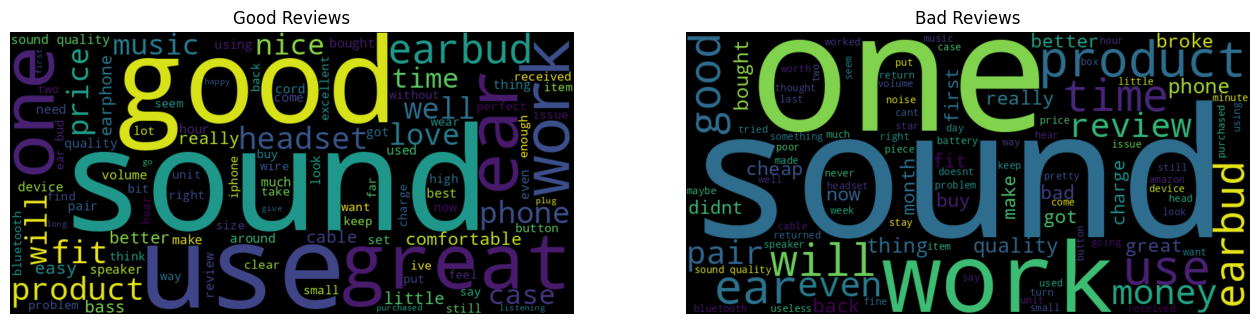

<function matplotlib.pyplot.show(close=None, block=None)>

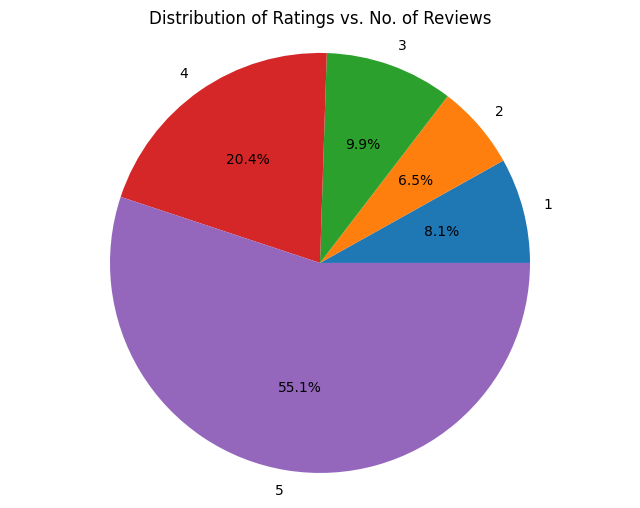

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# a. Top 20 most reviewed brands
most_reviewed_brands = merged_df['brand'].value_counts().head(20)
print("Top 20 most reviewed brands:")
print(most_reviewed_brands)

# b. Top 20 least reviewed brands
least_reviewed_brands = merged_df['brand'].value_counts().tail(20)
print("\nTop 20 least reviewed brands:")
print(least_reviewed_brands)

# c. Most positively reviewed 'Headphone'
most_positive_row = merged_df.loc[merged_df['overall'].idxmax()]
print("\nMost positively reviewed 'Headphone':")
print("ASIN:", most_positive_row['asin'])
print("Name:", most_positive_row['title'])
print("Brand:", most_positive_row['brand'])

# d. Count of ratings over 5 consecutive years
merged_df['reviewYear'] = pd.to_datetime(merged_df['reviewTime']).dt.year
rating_counts = merged_df.groupby('reviewYear')['overall'].value_counts().unstack().fillna(0).rolling(window=5, min_periods=1).sum().iloc[:-4]
print("\nCount of ratings over 5 consecutive years:")
print(rating_counts)

# e. Word Cloud for 'Good' and 'Bad' ratings
good_reviews = ' '.join(merged_df[(merged_df['overall'] >=4) & (~merged_df['reviewText'].str.contains('headphone', case=False))]['reviewText'].str.replace('[^a-zA-Z]', ' '))
bad_reviews = ' '.join(merged_df[(merged_df['overall'] < 2) & (~merged_df['reviewText'].str.contains('headphone', case=False))]['reviewText'].str.replace('[^a-zA-Z]', ' '))

# Generate word clouds
good_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(good_reviews)
bad_wordcloud = WordCloud(width=800, height=400, max_words=100).generate(bad_reviews)


plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(good_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Good Reviews')

plt.subplot(1, 2, 2)
plt.imshow(bad_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bad Reviews')
plt.show()

# f. Pie chart for Distribution of Ratings vs. No. of Reviews
rating_counts = merged_df['overall'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Ratings vs. No. of Reviews')
plt.axis('equal')
plt.show


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def encode_rating_class(rating):
    if rating > 3:
        return 'Good'
    elif rating == 3:
        return 'Average'
    else:
        return 'Bad'

merged_df['Rating Class'] = merged_df['overall'].apply(encode_rating_class)

# Step 2: Split the dataset into training and testing sets
X = merged_df['reviewText']
y = merged_df['Rating Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [10]:

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

models = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Classifier": SVC(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier()  
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    report = classification_report(y_test, y_pred, target_names=['Bad', 'Average', 'Good'], output_dict=True)
    results[name] = report


for name, metrics in results.items():
    print(f"Performance metrics for {name}:")
    print(f"Precision: {metrics['weighted avg']['precision']}")
    print(f"Recall: {metrics['weighted avg']['recall']}")
    print(f"F1-score: {metrics['weighted avg']['f1-score']}")
    print(f"Support: {metrics['weighted avg']['support']}\n")


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance metrics for Multinomial Naive Bayes:
Precision: 0.5504219927251253
Recall: 0.7419043015949734
F1-score: 0.6319773046327881
Support: 2069

Performance metrics for Logistic Regression:
Precision: 0.7794169639924521
Recall: 0.8144030932817786
F1-score: 0.7683140787343362
Support: 2069

Performance metrics for Support Vector Classifier:
Precision: 0.8056722791511531
Recall: 0.8090865152247463
F1-score: 0.7580290251340789
Support: 2069

Performance metrics for Random Forest Classifier:
Precision: 0.8101474081530555
Recall: 0.7738037699371677
F1-score: 0.7015633464979469
Support: 2069

Performance metrics for Gradient Boosting Classifier:
Precision: 0.75059157412262
Recall: 0.7849202513291446
F1-score: 0.7292441060256862
Support: 2069



new code 11

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def create_user_item_matrix(df):
    user_item_matrix = df.pivot_table(index='reviewerID', columns='asin', values='overall')
    user_item_matrix.fillna(0, inplace=True)  
    return user_item_matrix

def normalize_ratings(user_item_matrix):
    scaler = MinMaxScaler()
    normalized_matrix = scaler.fit_transform(user_item_matrix)
    return normalized_matrix

def find_top_similar_users(user_item_matrix, user_id, n=10):
    similarity_matrix = cosine_similarity(user_item_matrix)
    user_similarity = similarity_matrix[user_id]
    similar_users_indices = np.argsort(user_similarity)[::-1][1:n+1]  
    return similar_users_indices

def predict_rating(user_item_matrix, user_id, item_id, similar_users_indices, avg_ratings):
    numerator = 0
    denominator = 0
    for user_index in similar_users_indices:
        similarity = user_item_matrix[user_index, item_id]
        if similarity != 0:
            numerator += similarity * (user_item_matrix[user_index, item_id] - avg_ratings[user_index])
            denominator += similarity
    if denominator != 0:
        predicted_rating = numerator / denominator + avg_ratings[user_id]
    else:
        predicted_rating = avg_ratings[user_id]  
    return predicted_rating

# Initialize variables for different values of N
N_values = [10, 20, 30, 40, 50]
mae_values = []

# a) Create a user-item rating matrix
user_item_matrix = create_user_item_matrix(merged_df)

# b) Normalize the ratings
normalized_matrix = normalize_ratings(user_item_matrix)

# c) User-user recommender system
k = 5
kf = KFold(n_splits=k, shuffle=True)

# Iterate over different values of N
for N in N_values:
    # Initialize variables for error calculation
    errors = []

    # Iterate over folds
    for train_index, val_index in kf.split(normalized_matrix):
        train_set = normalized_matrix[train_index]
        val_set = normalized_matrix[val_index]

        avg_ratings = np.mean(train_set, axis=1)

        for user_id, item_ratings in enumerate(val_set):
            for item_id, rating in enumerate(item_ratings):
                if rating != 0:  
                    similar_users_indices = find_top_similar_users(train_set, user_id, n=N)
                    predicted_rating = predict_rating(train_set, user_id, item_id, similar_users_indices, avg_ratings)

                    actual_rating = val_set[user_id, item_id]
                    errors.append(abs(actual_rating - predicted_rating))

    # Calculate Mean Absolute Error for current value of N
    mae = np.mean(errors)
    mae_values.append(mae)

# Plot MAE vs. N
plt.plot(N_values, mae_values, marker='o')
plt.xlabel('Number of Nearest Neighbors (N)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Number of Nearest Neighbors for All Users')
plt.grid(True)
plt.show()


In [5]:
def create_item_user_matrix(df):
    item_user_matrix = df.pivot_table(index='asin', columns='reviewerID', values='overall')
    item_user_matrix.fillna(0, inplace=True)  
    return item_user_matrix

def find_top_similar_items(item_user_matrix, item_id, n=10):
    similarity_matrix = cosine_similarity(item_user_matrix.T)
    item_similarity = similarity_matrix[item_id]
    similar_items_indices = np.argsort(item_similarity)[::-1][1:n+1]  
    return similar_items_indices

# Initialize variables for different values of N
N_values = [10, 20, 30, 40, 50]
mae_values_item_item = []

# a) Create an item-user rating matrix
item_user_matrix = create_item_user_matrix(merged_df)

# b) Normalize the ratings
normalized_matrix_item_item = normalize_ratings(item_user_matrix)

# c) Item-item recommender system
k=5
kf = KFold(n_splits=k, shuffle=True)

# Iterate over different values of N
for N in N_values:
    # Initialize variables for error calculation
    errors_item_item = []

    # Iterate over folds
    for train_index, val_index in kf.split(normalized_matrix_item_item):
        train_set = normalized_matrix_item_item[train_index]
        val_set = normalized_matrix_item_item[val_index]

        avg_ratings = np.mean(train_set, axis=0)

        for item_id, user_ratings in enumerate(val_set.T):
            for user_id, rating in enumerate(user_ratings):
                if rating != 0:  
                    similar_items_indices = find_top_similar_items(train_set, item_id, n=N)
                    predicted_rating = predict_rating(train_set.T, item_id, user_id, similar_items_indices, avg_ratings)

                    actual_rating = val_set[user_id, item_id]
                    errors_item_item.append(abs(actual_rating - predicted_rating))

    # Calculate Mean Absolute Error for current value of N
    mae_item_item = np.mean(errors_item_item)
    mae_values_item_item.append(mae_item_item)

# Plot MAE vs. N for item-item recommender system
plt.plot(N_values, mae_values_item_item, marker='o', color='orange')
plt.xlabel('Number of Nearest Neighbors (N)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Number of Nearest Neighbors for Item-Item Recommender System')
plt.grid(True)
plt.show()

# Plot both graphs together
plt.plot(N_values, mae_values, marker='o', label='User-Item Recommender', color='blue')
plt.plot(N_values, mae_values_item_item, marker='o', label='Item-Item Recommender', color='orange')
plt.xlabel('Number of Nearest Neighbors (N)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE vs. Number of Nearest Neighbors')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
product_sum_ratings = merged_df.groupby('asin')['overall'].sum()

top_10_products = product_sum_ratings.sort_values(ascending=False).head(10)

print("Top 10 products by User Sum Ratings:")
print(top_10_products)

Top 10 products by User Sum Ratings:
asin
B00029MTMQ    10
B00008Z1QI    10
B00016556C    10
B00013BLEK    10
B00012F8AY    10
B0000UV2AW    10
B0000E3DQ7    10
B0000DZDHB    10
B0000ACCJA    10
B00009V2OV    10
Name: overall, dtype: int64
